In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
%matplotlib inline

from model import NN

In [2]:
def generate_ellipse(max_num = 10000, scale=(0.5,0.2)):
    data = (torch.rand((max_num,2))-0.5)*2
    dist = torch.sum(torch.square(data),axis=1)
    data = data[torch.where(dist <= 1)]
    data *= torch.tensor(scale)
    return data

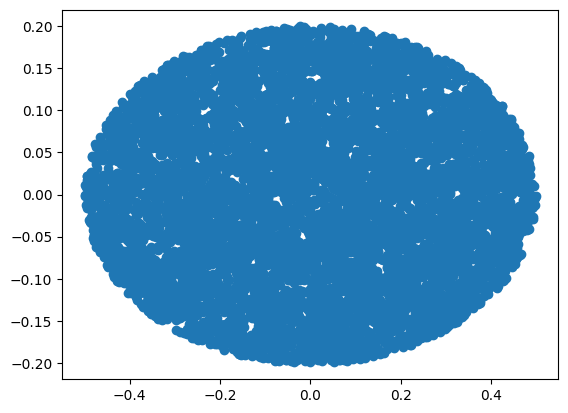

In [3]:
train_loader = generate_ellipse(max_num=10000, scale=(0.5,0.2))
plt.scatter(np.array(train_loader)[:,0], np.array(train_loader)[:,1])

In [4]:
torch.set_default_dtype(torch.float32)
torch.manual_seed(2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

# Training with uniform density

In [5]:
torch.manual_seed(0)

testNN = NN(num_lu_blocks=10,layer_size=2).to(device)

In [6]:
from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.SGD(testNN.parameters(), lr=1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.98)

In [7]:
from train import training_routine_uniform
from functions import uniform_circle_loss_function

In [8]:
%%time

num_epoch = 20
batch_size = 128
for epoch in range(num_epoch):
    density_param = (1+epoch, 0.2)
    training_routine_uniform(testNN, device, train_loader, optimizer, epoch, batch_size, uniform_circle_loss_function, density_param) 

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.05it/s]

CPU times: total: 48.3 s
Wall time: 48.9 s


In [9]:
from visuals import plot_generating_uniform_density, compute_uniform_circle_density


tensor([inf, inf, inf,  ..., inf, inf, inf], device='cuda:0') tensor([inf, inf, inf,  ..., inf, inf, inf], device='cuda:0') tensor([2.6335, 2.6267, 2.6199,  ..., 2.6061, 2.5984, 2.5917], device='cuda:0')


D:\master-thesis\acl\visuals.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, dtype=torch.float32).to(device), reverse=True)


0

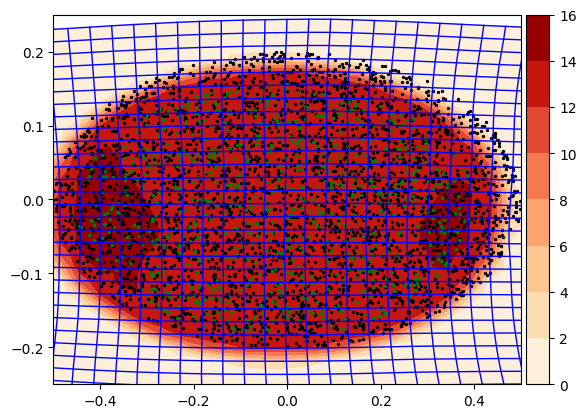

In [10]:
sampling_data = generate_ellipse(1000, (1, 1))

plot_generating_uniform_density(testNN, device, density_param, train_loader, sampling_data, grid_width=30,
                                x_range=(-1.5, 1.5), y_range=(-1.5, 1.5), x_lim=(-0.5,0.5), y_lim=(-0.25,0.25),
                                density_function=compute_uniform_circle_density)

# Training with Gaussian Density

In [43]:
torch.manual_seed(0)

testNN = NN(num_lu_blocks=20,layer_size=2).to(device)

In [44]:
from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.SGD(testNN.parameters(), lr=1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.98)

In [45]:
from train import training_routine_gaussian
from functions import gaussian_loss_function

In [46]:
%%time

num_epoch = 20
batch_size = 128
for epoch in range(num_epoch):
    training_routine_gaussian(testNN, device, train_loader, optimizer, epoch, batch_size) 

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.13it/s]

CPU times: total: 1min 35s
Wall time: 1min 35s


In [15]:
from visuals import plot_generating_gaussian_density, compute_gaussian_density


In [47]:
sampling_data = torch.normal(torch.zeros(1000,2), torch.ones(1000,2))
sampling_data

tensor([[ 0.9912, -0.8071],
        [ 1.2902,  0.1833],
        [-2.8289,  1.3828],
        ...,
        [-0.4756,  0.3707],
        [-0.4081,  0.3677],
        [ 0.2857, -0.8561]])

torch.Size([1800]) torch.Size([1800, 20])
tensor([6.6922, 6.0929, 5.5372,  ..., 4.6501, 5.1633, 5.7187], device='cuda:0') tensor(1.1447, dtype=torch.float64) tensor([9.0000, 8.4007, 7.8442,  ..., 7.8442, 8.4007, 9.0000], device='cuda:0') tensor([3.4525, 3.4526, 3.4518,  ..., 4.3388, 4.3821, 4.4260], device='cuda:0')


0

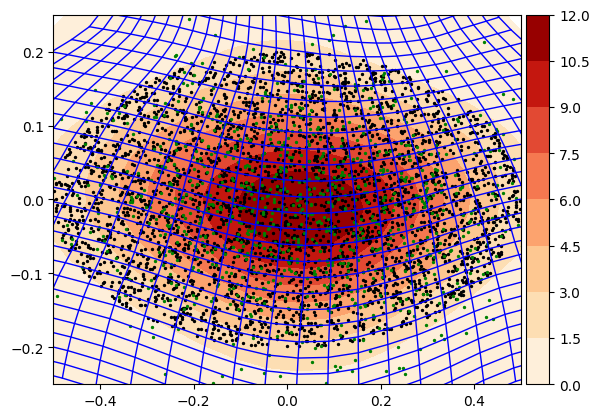

In [48]:
plot_generating_gaussian_density(testNN, device, density_param, train_loader, sampling_data.detach(), grid_width=30,
                                x_range=(-3, 3), y_range=(-3, 3), x_lim=(-0.5,0.5), y_lim=(-0.25,0.25))